In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dropout, Dense, GRU, RNN, Embedding, Concatenate
from tensorflow.keras.layers import Bidirectional, Input, LayerNormalization, Reshape, GlobalAveragePooling1D
from gensim.models import Word2Vec, FastText
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

from sklearn.utils import shuffle
import scikitplot as skplt


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer



In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
tf.__version__

'2.3.0'

In [4]:
df = pd.read_csv('TrainData.csv')
df_test = pd.read_csv('Assignment4_TestLabels.csv')

In [5]:
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


In [6]:
df_test.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [40]:
y_train = df['Category']
X_train = df.drop(['Category'],axis=1)
X_train = X_train.reset_index(drop=True)

y_test = df_test['Category']
X_test = df_test.drop(['ArticleId', 'Category'],axis=1)

print('before: %s ...' %y_train[:5])

#Transform label names to unique number using label encoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object ...
after: [0 0 0 ... 0 4 4] ...


In [41]:
print(np.bincount(y_train))
print(le.inverse_transform([i for i in range(5)]))

[336 273 274 346 261]
['business' 'entertainment' 'politics' 'sport' 'tech']


In [42]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [43]:
X_train['text'] = preprocess(X_train['Text'])
X_test['text'] = preprocess(X_test['Text'])

In [44]:
import re

lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [45]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [46]:
from tensorflow.keras.utils import to_categorical

maxlen= 500
vocab_size = 20000

tokenizer = Tokenizer(nb_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

len_max=0
grt = 0
for i in sequences:
    len_max = max(len_max, len(i))
    if len(i)>400:
        grt += 1

print('max len: ',len_max)
print('grt : ', grt)

data = pad_sequences(sequences, maxlen=max_seq_len)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

xtrain = data
ytrain = labels
# xval = data[-nb_validation_samples:]
# yval = labels[-nb_validation_samples:]

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 25316 unique tokens.
max len:  1643
grt :  73
Shape of data tensor: (1490, 500)
Shape of label tensor: (1490, 5)


In [47]:
from sklearn.metrics import f1_score

def find_test_acc(prediction):
  y_pred = []
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    y_pred.append(name[0])
#     print(name[0])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")
  print('micro average f1 score: ', f1_score(y_test, y_pred, average='micro'))

def predict_test(model, len_list_embed, history):
  #Tokenize test data and apply model prediction
    sequences = tokenizer.texts_to_sequences(test_text)
    data = pad_sequences(sequences, maxlen=max_seq_len)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    prediction = model.predict([data]*len_list_embed)
    find_test_acc(prediction)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.show()


In [48]:
def plot_history(history, model, val):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.show()
    

    y_pred = (model.predict([X_test]*val) > 0.5).astype("int32")
    (skplt.metrics.plot_confusion_matrix(y_pred, y_test, cmap='Oranges', title="Test data"))

    y_pred = (model.predict([X_train]*val) > 0.5).astype("int32")
    (skplt.metrics.plot_confusion_matrix(y_pred, y_train, title="Train data"))



In [49]:
class AverageWords(layers.Layer):
    def __init__(self):
        super(AverageWords,self).__init__()
        self.supports_masking = True

    def call(self, x, mask=None):
        axis = K.ndim(x) - 2
        if mask is not None:
            summed = K.sum(x, axis=axis)
            n_words = K.expand_dims(K.sum(K.cast(mask, 'float32'), axis=axis), axis)
            return summed / n_words
        else:
            return K.mean(x, axis=axis)

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        dimensions = list(input_shape)
        n_dimensions = len(input_shape)
        del dimensions[n_dimensions - 2]
        return tuple(dimensions)

class WordDropout(layers.Layer):
    def __init__(self, rate):
        super(WordDropout,self).__init__()
        self.rate = min(1., max(0., rate))
        self.supports_masking = True

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.0:
            def dropped_inputs():
                input_shape = K.shape(inputs)
                batch_size = input_shape[0]
                n_time_steps = input_shape[1]
                mask = tf.random.uniform((batch_size, n_time_steps, 1)) >= self.rate
                w_drop = K.cast(mask, 'float32') * inputs
                return w_drop
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

    def get_config(self):
        config = {'rate': self.rate}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [53]:
X_train = xtrain
y_train = ytrain

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
embed_dim = 200

model = Sequential()
embed_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxlen)
model.add(embed_layer)

model.add(WordDropout(0.3))
model.add(AverageWords())

model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                epochs=200,
                verbose=True,
                validation_split = 0.2,
                batch_size=32,
                callbacks=[earlystop]
                )


Epoch 1/200
38/38 [==============================] - 2s 43ms/step - loss: 1.5987 - accuracy: 0.2315 - val_loss: 1.5701 - val_accuracy: 0.2651
Epoch 2/200
38/38 [==============================] - 1s 36ms/step - loss: 1.5492 - accuracy: 0.3247 - val_loss: 1.4457 - val_accuracy: 0.4027
Epoch 3/200
38/38 [==============================] - 1s 31ms/step - loss: 1.3634 - accuracy: 0.5394 - val_loss: 1.0507 - val_accuracy: 0.6275
Epoch 4/200
38/38 [==============================] - 1s 39ms/step - loss: 0.9228 - accuracy: 0.7055 - val_loss: 0.6095 - val_accuracy: 0.7483
Epoch 5/200
38/38 [==============================] - 1s 31ms/step - loss: 0.5745 - accuracy: 0.8221 - val_loss: 0.3803 - val_accuracy: 0.8960
Epoch 6/200
38/38 [==============================] - 1s 38ms/step - loss: 0.3742 - accuracy: 0.9069 - val_loss: 0.2310 - val_accuracy: 0.9195
Epoch 7/200
38/38 [==============================] - 1s 30ms/step - loss: 0.2108 - accuracy: 0.9690 - val_loss: 0.1464 - val_accuracy: 0.9564
Epoch 

Shape of data tensor: (735, 500)
Shape of label tensor: (1490, 5)
Test Accuracy: 97.14285714285714 %
micro average f1 score:  0.9714285714285714


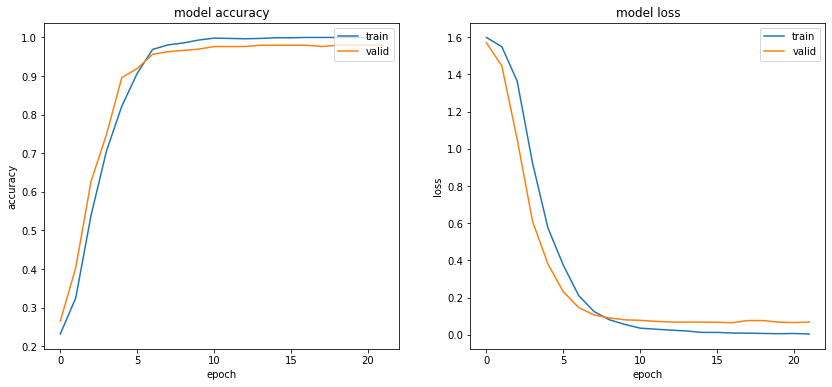

In [54]:
predict_test(model, 1, history)

Epoch 1/200
38/38 [==============================] - 1s 37ms/step - loss: 1.6025 - accuracy: 0.2223 - val_loss: 1.5771 - val_accuracy: 0.2584
Epoch 2/200
38/38 [==============================] - 1s 31ms/step - loss: 1.5613 - accuracy: 0.2743 - val_loss: 1.4733 - val_accuracy: 0.3960
Epoch 3/200
38/38 [==============================] - 1s 32ms/step - loss: 1.4052 - accuracy: 0.5008 - val_loss: 1.1404 - val_accuracy: 0.7953
Epoch 4/200
38/38 [==============================] - 1s 28ms/step - loss: 1.0348 - accuracy: 0.7576 - val_loss: 0.6402 - val_accuracy: 0.8993
Epoch 5/200
38/38 [==============================] - 1s 32ms/step - loss: 0.5920 - accuracy: 0.9035 - val_loss: 0.3077 - val_accuracy: 0.9530
Epoch 6/200
38/38 [==============================] - 1s 26ms/step - loss: 0.2898 - accuracy: 0.9581 - val_loss: 0.1826 - val_accuracy: 0.9530
Epoch 7/200
38/38 [==============================] - 1s 35ms/step - loss: 0.1607 - accuracy: 0.9773 - val_loss: 0.1265 - val_accuracy: 0.9664
Epoch 

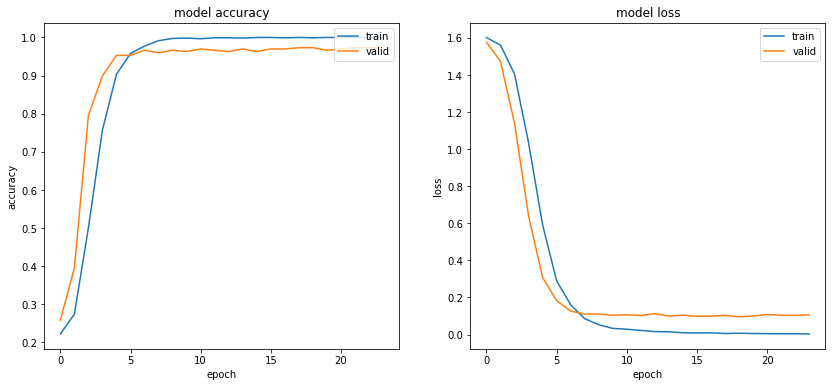

Epoch 1/200
38/38 [==============================] - 1s 32ms/step - loss: 1.6006 - accuracy: 0.2550 - val_loss: 1.5717 - val_accuracy: 0.3389
Epoch 2/200
38/38 [==============================] - 1s 31ms/step - loss: 1.5482 - accuracy: 0.3901 - val_loss: 1.4361 - val_accuracy: 0.4799
Epoch 3/200
38/38 [==============================] - 1s 35ms/step - loss: 1.3417 - accuracy: 0.5587 - val_loss: 1.0243 - val_accuracy: 0.6040
Epoch 4/200
38/38 [==============================] - 1s 32ms/step - loss: 0.8952 - accuracy: 0.7399 - val_loss: 0.5740 - val_accuracy: 0.8054
Epoch 5/200
38/38 [==============================] - 1s 36ms/step - loss: 0.4962 - accuracy: 0.9060 - val_loss: 0.2448 - val_accuracy: 0.9564
Epoch 6/200
38/38 [==============================] - 1s 31ms/step - loss: 0.2472 - accuracy: 0.9631 - val_loss: 0.1387 - val_accuracy: 0.9597
Epoch 7/200
38/38 [==============================] - 1s 30ms/step - loss: 0.1321 - accuracy: 0.9832 - val_loss: 0.1373 - val_accuracy: 0.9396
Epoch 

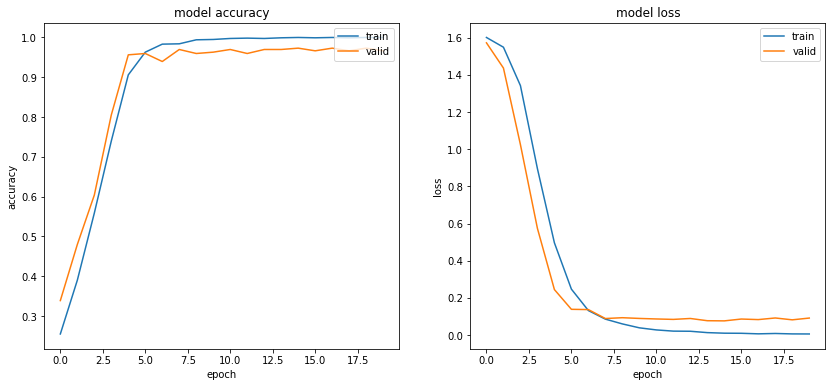

Epoch 1/200
38/38 [==============================] - 1s 37ms/step - loss: 1.5999 - accuracy: 0.2735 - val_loss: 1.5750 - val_accuracy: 0.3087
Epoch 2/200
38/38 [==============================] - 1s 35ms/step - loss: 1.5444 - accuracy: 0.4136 - val_loss: 1.4444 - val_accuracy: 0.4664
Epoch 3/200
38/38 [==============================] - 1s 27ms/step - loss: 1.3470 - accuracy: 0.5336 - val_loss: 1.0696 - val_accuracy: 0.5973
Epoch 4/200
38/38 [==============================] - 1s 35ms/step - loss: 0.9466 - accuracy: 0.6602 - val_loss: 0.6599 - val_accuracy: 0.7685
Epoch 5/200
38/38 [==============================] - 1s 31ms/step - loss: 0.5853 - accuracy: 0.8448 - val_loss: 0.3582 - val_accuracy: 0.9060
Epoch 6/200
38/38 [==============================] - 1s 36ms/step - loss: 0.3398 - accuracy: 0.9404 - val_loss: 0.2163 - val_accuracy: 0.9362
Epoch 7/200
38/38 [==============================] - 1s 30ms/step - loss: 0.2112 - accuracy: 0.9631 - val_loss: 0.1773 - val_accuracy: 0.9430
Epoch 

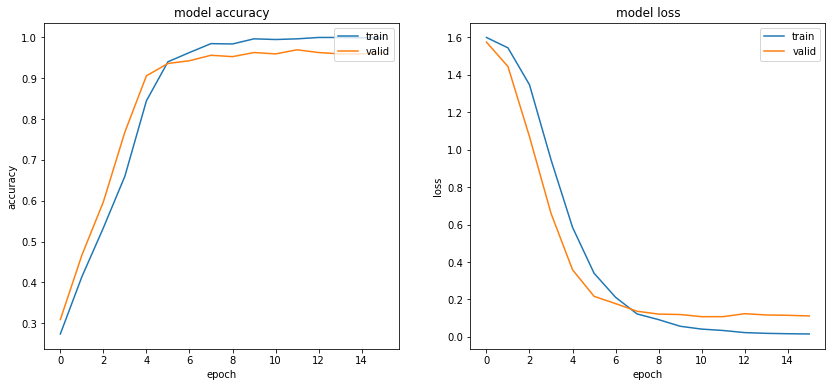

Epoch 1/200
38/38 [==============================] - 2s 40ms/step - loss: 1.5947 - accuracy: 0.2542 - val_loss: 1.5666 - val_accuracy: 0.4362
Epoch 2/200
38/38 [==============================] - 1s 29ms/step - loss: 1.5373 - accuracy: 0.3624 - val_loss: 1.4180 - val_accuracy: 0.5738
Epoch 3/200
38/38 [==============================] - 1s 35ms/step - loss: 1.3213 - accuracy: 0.6082 - val_loss: 1.0095 - val_accuracy: 0.6913
Epoch 4/200
38/38 [==============================] - 1s 31ms/step - loss: 0.9025 - accuracy: 0.7391 - val_loss: 0.5616 - val_accuracy: 0.8020
Epoch 5/200
38/38 [==============================] - 1s 33ms/step - loss: 0.5411 - accuracy: 0.8591 - val_loss: 0.3075 - val_accuracy: 0.9228
Epoch 6/200
38/38 [==============================] - 1s 26ms/step - loss: 0.3060 - accuracy: 0.9522 - val_loss: 0.1783 - val_accuracy: 0.9597
Epoch 7/200
38/38 [==============================] - 1s 36ms/step - loss: 0.1608 - accuracy: 0.9799 - val_loss: 0.1449 - val_accuracy: 0.9530
Epoch 

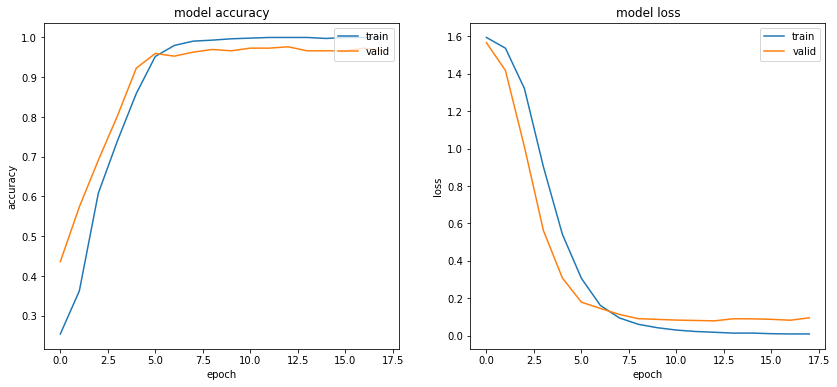

Epoch 1/200
38/38 [==============================] - 2s 47ms/step - loss: 1.5988 - accuracy: 0.2475 - val_loss: 1.5625 - val_accuracy: 0.3523
Epoch 2/200
38/38 [==============================] - 1s 33ms/step - loss: 1.5409 - accuracy: 0.3540 - val_loss: 1.4301 - val_accuracy: 0.5000
Epoch 3/200
38/38 [==============================] - 1s 35ms/step - loss: 1.3223 - accuracy: 0.5940 - val_loss: 0.9981 - val_accuracy: 0.6577
Epoch 4/200
38/38 [==============================] - 1s 31ms/step - loss: 0.8618 - accuracy: 0.7676 - val_loss: 0.5115 - val_accuracy: 0.9094
Epoch 5/200
38/38 [==============================] - 1s 37ms/step - loss: 0.4599 - accuracy: 0.8985 - val_loss: 0.2733 - val_accuracy: 0.9362
Epoch 6/200
38/38 [==============================] - 1s 33ms/step - loss: 0.2512 - accuracy: 0.9539 - val_loss: 0.1377 - val_accuracy: 0.9631
Epoch 7/200
38/38 [==============================] - 1s 37ms/step - loss: 0.1346 - accuracy: 0.9807 - val_loss: 0.1152 - val_accuracy: 0.9698
Epoch 

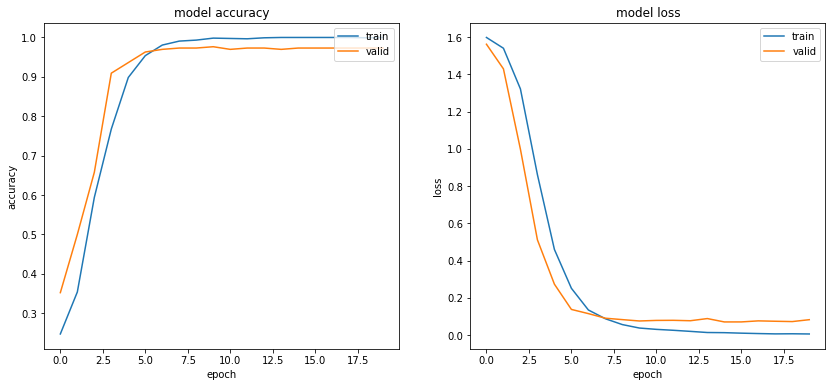

In [55]:
for i in range(5):
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    embed_dim = 200

    model = Sequential()
    embed_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxlen)
    model.add(embed_layer)

    model.add(WordDropout(0.3))
    model.add(AverageWords())

    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(30, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=True,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[earlystop]
                    )
    predict_test(model, 1, history)

In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
word_dropout_5 (WordDropout) (None, 500, 300)          0         
_________________________________________________________________
average_words_5 (AverageWord (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                15050     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)               

# Transformer - Encoder model

In [57]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2


class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)



In [2]:
encoder_block = Encoder(num_layers=3, d_model=40, num_heads=5,
                         dff=40, input_vocab_size=vocab_size,
                         maximum_position_encoding=maxlen)

In [81]:
inputs = Input(shape=(maxlen,))
enc_padding_mask = create_padding_mask(inputs)
x = encoder_block(inputs, training=True, mask = enc_padding_mask)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [82]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Equal_4 (TensorFlow [(None, 500)]        0           input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Cast_4 (TensorFlowO [(None, 500)]        0           tf_op_layer_Equal_4[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 1, 1, 500)]  0           tf_op_layer_Cast_4[0][0]         
_______________________________________________________________________________________

In [83]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
  X_train, y_train, batch_size=32, epochs=200, validation_split=0.2,
  callbacks=[earlystop]
)

Epoch 1/200
38/38 [==============================] - 4s 114ms/step - loss: 1.7508 - accuracy: 0.2081 - val_loss: 1.6073 - val_accuracy: 0.2584
Epoch 2/200
38/38 [==============================] - 3s 80ms/step - loss: 1.6196 - accuracy: 0.2156 - val_loss: 1.6009 - val_accuracy: 0.2349
Epoch 3/200
38/38 [==============================] - 4s 93ms/step - loss: 1.6296 - accuracy: 0.2508 - val_loss: 1.6056 - val_accuracy: 0.2013
Epoch 4/200
38/38 [==============================] - 3s 83ms/step - loss: 1.6108 - accuracy: 0.2290 - val_loss: 1.6048 - val_accuracy: 0.2013
Epoch 5/200
38/38 [==============================] - 4s 98ms/step - loss: 1.6107 - accuracy: 0.2357 - val_loss: 1.6044 - val_accuracy: 0.2013
Epoch 6/200
38/38 [==============================] - 3s 86ms/step - loss: 1.6037 - accuracy: 0.2341 - val_loss: 1.6002 - val_accuracy: 0.2047
Epoch 7/200
38/38 [==============================] - 4s 100ms/step - loss: 1.5666 - accuracy: 0.2878 - val_loss: 1.4477 - val_accuracy: 0.4933
Epoc

Shape of data tensor: (735, 500)
Shape of label tensor: (1490, 5)
Test Accuracy: 97.00680272108843 %
micro average f1 score:  0.9700680272108844


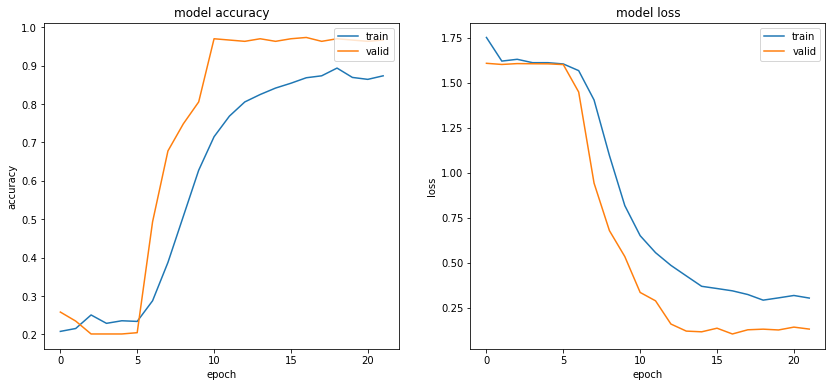

In [84]:
predict_test(model, 1, history)

Epoch 1/200
38/38 [==============================] - 4s 116ms/step - loss: 1.3764 - accuracy: 0.4614 - val_loss: 0.5014 - val_accuracy: 0.8356
Epoch 2/200
38/38 [==============================] - 3s 80ms/step - loss: 0.7318 - accuracy: 0.6846 - val_loss: 0.2744 - val_accuracy: 0.9631
Epoch 3/200
38/38 [==============================] - 4s 98ms/step - loss: 0.6320 - accuracy: 0.7181 - val_loss: 0.2120 - val_accuracy: 0.9765
Epoch 4/200
38/38 [==============================] - 3s 80ms/step - loss: 0.4953 - accuracy: 0.7768 - val_loss: 0.1356 - val_accuracy: 0.9832
Epoch 5/200
38/38 [==============================] - 3s 80ms/step - loss: 0.4266 - accuracy: 0.7810 - val_loss: 0.1038 - val_accuracy: 0.9799
Epoch 6/200
38/38 [==============================] - 3s 89ms/step - loss: 0.3886 - accuracy: 0.8213 - val_loss: 0.0780 - val_accuracy: 0.9832
Epoch 7/200
38/38 [==============================] - 3s 86ms/step - loss: 0.3402 - accuracy: 0.8473 - val_loss: 0.0703 - val_accuracy: 0.9765
Epoch

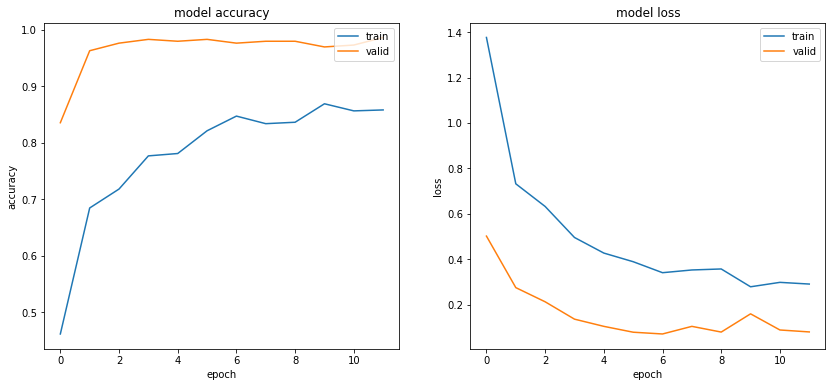

Epoch 1/200
38/38 [==============================] - 4s 110ms/step - loss: 1.4236 - accuracy: 0.4329 - val_loss: 0.6054 - val_accuracy: 0.8725
Epoch 2/200
38/38 [==============================] - 3s 82ms/step - loss: 0.7791 - accuracy: 0.6636 - val_loss: 0.3501 - val_accuracy: 0.9765
Epoch 3/200
38/38 [==============================] - 3s 81ms/step - loss: 0.5800 - accuracy: 0.7626 - val_loss: 0.2649 - val_accuracy: 0.9631
Epoch 4/200
38/38 [==============================] - 4s 97ms/step - loss: 0.5096 - accuracy: 0.7827 - val_loss: 0.1929 - val_accuracy: 0.9765
Epoch 5/200
38/38 [==============================] - 3s 78ms/step - loss: 0.4783 - accuracy: 0.7861 - val_loss: 0.2129 - val_accuracy: 0.9765
Epoch 6/200
38/38 [==============================] - 4s 99ms/step - loss: 0.4402 - accuracy: 0.8389 - val_loss: 0.1901 - val_accuracy: 0.9765
Epoch 7/200
38/38 [==============================] - 3s 85ms/step - loss: 0.3888 - accuracy: 0.8633 - val_loss: 0.1870 - val_accuracy: 0.9732
Epoch

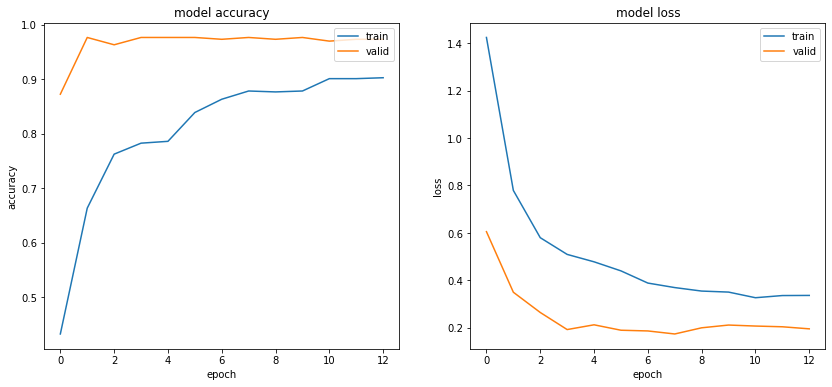

Epoch 1/200
38/38 [==============================] - 4s 115ms/step - loss: 1.1892 - accuracy: 0.5596 - val_loss: 0.2765 - val_accuracy: 0.9664
Epoch 2/200
38/38 [==============================] - 3s 84ms/step - loss: 0.6333 - accuracy: 0.7366 - val_loss: 0.2072 - val_accuracy: 0.9530
Epoch 3/200
38/38 [==============================] - 4s 100ms/step - loss: 0.4681 - accuracy: 0.8012 - val_loss: 0.1541 - val_accuracy: 0.9631
Epoch 4/200
38/38 [==============================] - 4s 96ms/step - loss: 0.4374 - accuracy: 0.8188 - val_loss: 0.1798 - val_accuracy: 0.9765
Epoch 5/200
38/38 [==============================] - 3s 83ms/step - loss: 0.4100 - accuracy: 0.8465 - val_loss: 0.1468 - val_accuracy: 0.9698
Epoch 6/200
38/38 [==============================] - 4s 102ms/step - loss: 0.3503 - accuracy: 0.8708 - val_loss: 0.1405 - val_accuracy: 0.9732
Epoch 7/200
38/38 [==============================] - 3s 82ms/step - loss: 0.3298 - accuracy: 0.8674 - val_loss: 0.1296 - val_accuracy: 0.9765
Epo

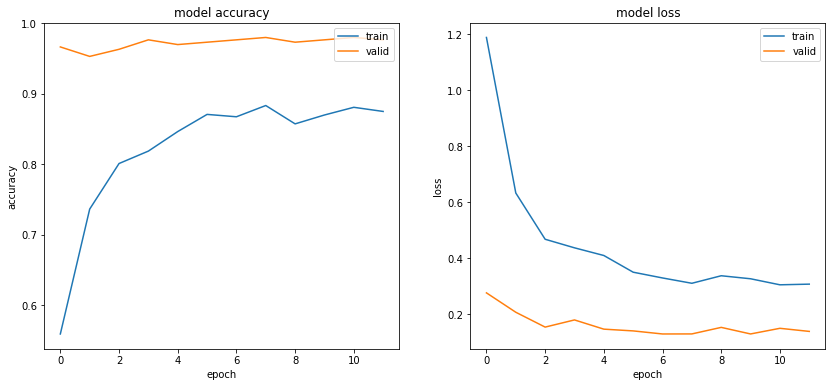

Epoch 1/200
38/38 [==============================] - 5s 124ms/step - loss: 1.4193 - accuracy: 0.4346 - val_loss: 0.4365 - val_accuracy: 0.9698
Epoch 2/200
38/38 [==============================] - 3s 84ms/step - loss: 0.7730 - accuracy: 0.6527 - val_loss: 0.2462 - val_accuracy: 0.9732
Epoch 3/200
38/38 [==============================] - 3s 88ms/step - loss: 0.6087 - accuracy: 0.7248 - val_loss: 0.1756 - val_accuracy: 0.9799
Epoch 4/200
38/38 [==============================] - 3s 90ms/step - loss: 0.5025 - accuracy: 0.7768 - val_loss: 0.1667 - val_accuracy: 0.9664
Epoch 5/200
38/38 [==============================] - 3s 82ms/step - loss: 0.4591 - accuracy: 0.8196 - val_loss: 0.1263 - val_accuracy: 0.9765
Epoch 6/200
38/38 [==============================] - 3s 80ms/step - loss: 0.4132 - accuracy: 0.8565 - val_loss: 0.1103 - val_accuracy: 0.9732
Epoch 7/200
38/38 [==============================] - 4s 100ms/step - loss: 0.3310 - accuracy: 0.8758 - val_loss: 0.1445 - val_accuracy: 0.9698
Epoc

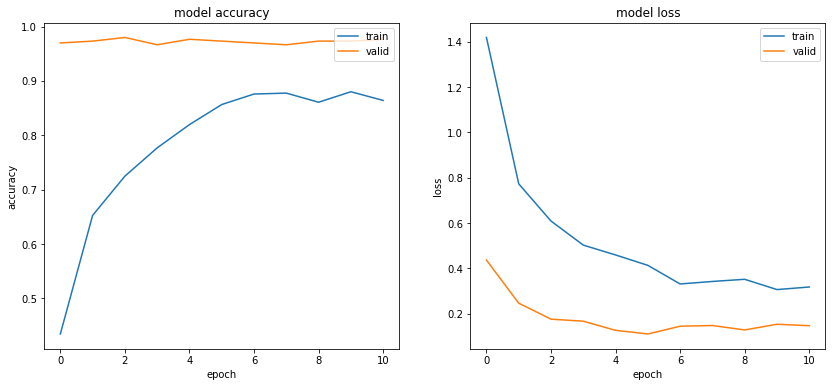

Epoch 1/200
38/38 [==============================] - 5s 141ms/step - loss: 1.4850 - accuracy: 0.4312 - val_loss: 0.4856 - val_accuracy: 0.9664
Epoch 2/200
38/38 [==============================] - 3s 79ms/step - loss: 0.6721 - accuracy: 0.7248 - val_loss: 0.3016 - val_accuracy: 0.9664
Epoch 3/200
38/38 [==============================] - 4s 98ms/step - loss: 0.5030 - accuracy: 0.7852 - val_loss: 0.2024 - val_accuracy: 0.9698
Epoch 4/200
38/38 [==============================] - 3s 83ms/step - loss: 0.4255 - accuracy: 0.8213 - val_loss: 0.1840 - val_accuracy: 0.9732
Epoch 5/200
38/38 [==============================] - 3s 83ms/step - loss: 0.4136 - accuracy: 0.8180 - val_loss: 0.2203 - val_accuracy: 0.9664
Epoch 6/200
38/38 [==============================] - 3s 78ms/step - loss: 0.4019 - accuracy: 0.8272 - val_loss: 0.1304 - val_accuracy: 0.9799
Epoch 7/200
38/38 [==============================] - 3s 91ms/step - loss: 0.3393 - accuracy: 0.8540 - val_loss: 0.1424 - val_accuracy: 0.9765
Epoch

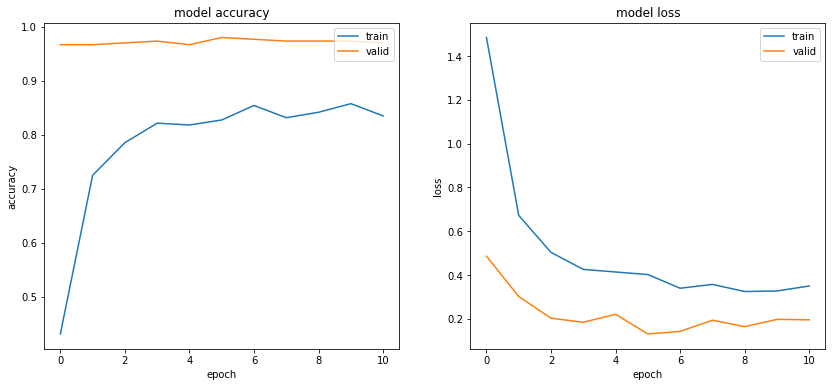

In [86]:
for i in range(5):
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    inputs = Input(shape=(maxlen,))
    enc_padding_mask = create_padding_mask(inputs)
    x = encoder_block(inputs, training=True, mask = enc_padding_mask)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(12, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(
      X_train, y_train, batch_size=32, epochs=200, 
      validation_split=0.2,
      callbacks=[earlystop]
    )
    predict_test(model, 1, history)